# Fine-Tuning no ICDAR 2019 - Approach 3

## Abordagem congelando a efficient-net e T5 deixando apenas a ConvGRU livre e treinável.

## Enunciado

O objetivo deste exercício é treinar uma rede similar à da aula 7 (CNN como codificadora + decodificador do transformer) mas tendo como entrada imagens de recibos reais. A saída esperada é o nome da compania e seu endereço. 

Iremos usar o [dataset SROIE da competição ICDAR 2019.](https://rrc.cvc.uab.es/?ch=13&com=introduction)

Métricas: usar o código abaixo para calcular o exact match da resposta toda e F1 de palavras.

In [1]:
version = "finetuning_augm_extract_app3_adafactor_seqred_test1" #@param {type: "string"}
bs =    12#@param {type: "integer"} 
accum =    6#@param {type: "integer"} 
seq_len =  64#@param {type: "integer"}
patience =  10#@param {type: "integer"}
max_epochs =  500#@param {type: "integer"}
dropout_rate = 0.3#@param {type: "number"}
drop_connect_rate = 0.5#@param {type: "number"}
debug = False #@param {type: "boolean"}


# Define hyperparameters
hparams = {"version": version,
           "bs": bs,
           "accum": accum,
           "seq_len": seq_len,
           "patience": patience,
           "max_epochs": max_epochs,
           "dropout_rate": dropout_rate,
           "drop_connect_rate": drop_connect_rate,
           "debug": debug, 
           "enet": "efficientnet-b0",
           "t5": "t5-small"}
hparams             

{'accum': 6,
 'bs': 12,
 'debug': False,
 'drop_connect_rate': 0.5,
 'dropout_rate': 0.3,
 'enet': 'efficientnet-b0',
 'max_epochs': 500,
 'patience': 10,
 'seq_len': 64,
 't5': 't5-small',
 'version': 'finetuning_augm_extract_app3_adafactor_seqred_test1'}

In [2]:
import nvidia_smi
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


## Download do dataset

In [4]:
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip .
!unzip dataset_sroie_icdar_2019.zip

Copying gs://neuralresearcher_data/unicamp/ia376j_2020s2/aula8/dataset_sroie_icdar_2019.zip...
- [1/1 files][268.8 MiB/268.8 MiB] 100% Done                                    
Operation completed over 1 objects/268.8 MiB.                                    
Archive:  dataset_sroie_icdar_2019.zip
   creating: test/
  inflating: test/X51008099073.txt   
  inflating: test/X51008099089.txt   
  inflating: test/X51008099081.jpg   
  inflating: test/X51008114260.jpg   
  inflating: test/X51008099054.jpg   
  inflating: test/X51008099073.jpg   
  inflating: test/X51008114260.txt   
  inflating: test/X51008114217.txt   
  inflating: test/X51008099102.txt   
  inflating: test/X51008099102.jpg   
  inflating: test/X51008114216.jpg   
  inflating: test/X51008114262.txt   
  inflating: test/X51008123447.jpg   
  inflating: test/X51008099083.jpg   
  inflating: test/X51008114266.txt   
  inflating: test/X51008122920.jpg   
  inflating: test/X51008114283.txt   
  inflating: test/X51008114321.jpg   


O dataset contém 626 imagens e suas respectiva anotações (respostas), sendo 200 imagens separadas para teste. Cada imagem tem um arquivo txt correspondente que contém as respostas em formato json.

In [5]:
!pip install neptune-client --quiet 

     |████████████████████████████████| 102kB 5.7MB/s 
     |████████████████████████████████| 829kB 13.0MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 204kB 28.4MB/s 
     |████████████████████████████████| 163kB 49.4MB/s 
     |████████████████████████████████| 133kB 52.8MB/s 
     |████████████████████████████████| 71kB 11.3MB/s 
     |████████████████████████████████| 71kB 11.5MB/s 


In [6]:
!pip install fairseq --quiet 

     |████████████████████████████████| 1.7MB 13.2MB/s 
     |████████████████████████████████| 71kB 11.7MB/s 
     |████████████████████████████████| 133kB 59.9MB/s 
     |████████████████████████████████| 112kB 63.5MB/s 
     |████████████████████████████████| 276kB 55.5MB/s 


In [7]:
!pip install sacrebleu pytorch-lightning transformers==3.5.1 efficientnet-pytorch --quiet     

     |████████████████████████████████| 686kB 14.3MB/s 
     |████████████████████████████████| 1.3MB 24.9MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 1.1MB 36.0MB/s 
     |████████████████████████████████| 890kB 60.1MB/s 
     |████████████████████████████████| 2.9MB 57.4MB/s 
     |████████████████████████████████| 1.3MB 56.0MB/s 
     |████████████████████████████████| 296kB 55.5MB/s 
     |████████████████████████████████| 143kB 65.3MB/s 


In [8]:
!mkdir "output"

In [9]:
import os
import numpy as np
import shutil
import random
import glob

# # Creating Train / Val / Test folders (One time use)
root_dir = 'output'
mode = 'train'
val_ratio = 0.25
src_dir = 'train'

os.makedirs(root_dir +'/train')
os.makedirs(root_dir +'/val')

allFileNames = glob.glob(f"{mode}/*.txt")
np.random.shuffle(allFileNames)
train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                [int(len(allFileNames)* (1 - val_ratio))])


train_FileNames = [name for name in train_FileNames.tolist()]
val_FileNames = [name for name in val_FileNames.tolist()]

print('Total images: ', len(allFileNames))
print('Training: ', len(train_FileNames))
print('Validation: ', len(val_FileNames))

# Copy-pasting images
for name in train_FileNames:
    shutil.copy(name, root_dir +'/train')
    shutil.copy(name[:-4]+'.jpg', root_dir +'/train')

for name in val_FileNames:
    shutil.copy(name, root_dir +'/val')
    shutil.copy(name[:-4]+'.jpg', root_dir +'/val')


Total images:  426
Training:  319
Validation:  107


In [10]:
import json
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from efficientnet_pytorch import EfficientNet
import os
import json
import random
import gc
from fairseq.optim import adafactor
import cv2
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, ToTensor, Compose
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from transformers import T5Tokenizer, T5ForConditionalGeneration
import sacrebleu
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [11]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

def gpu_usage():
    global handle
    return str(nvidia_smi.nvmlDeviceGetUtilizationRates(handle).gpu) + '%'

Pytorch Lightning Version: 1.1.3
Device name: b'Tesla P100-PCIE-16GB'


In [12]:
data_json = json.load(open("train/X00016469612.txt"))
print(data_json)

print(data_json["company"])
print(data_json["address"])

{'company': 'BOOK TA .K (TAMAN DAYA) SDN BHD', 'date': '25/12/2018', 'address': 'NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.', 'total': '9.00'}
BOOK TA .K (TAMAN DAYA) SDN BHD
NO.53 55,57 & 59, JALAN SAGU 18, TAMAN DAYA, 81100 JOHOR BAHRU, JOHOR.


In [13]:
TOKENIZER = T5Tokenizer.from_pretrained(hparams['t5'])

extra_tokens = ['[NL]'] # Add token de 'nova linha' para multiline
added_tokens = []
for tok in extra_tokens:
  enc = TOKENIZER.encode(tok)
  if 2 in enc:
      added_tokens.append(tok)
      TOKENIZER.add_tokens(tok)

# Remover espaço em branco (apresentado pelo diedre)

Area Ratio: 0.29614160348092544
Width Height Ratio: 0.31994362226920364


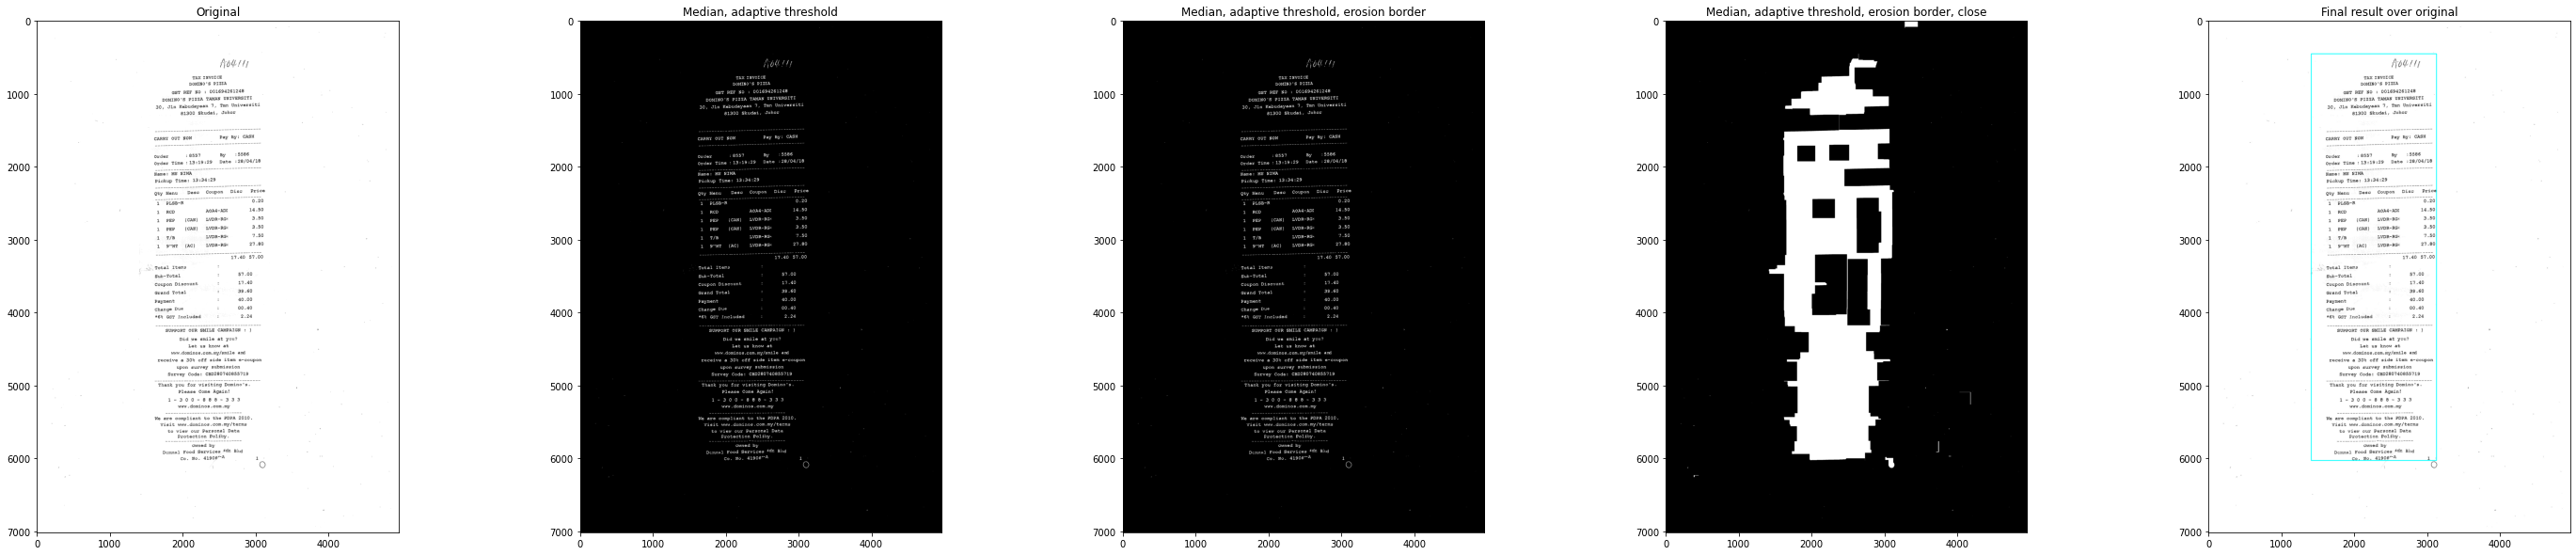

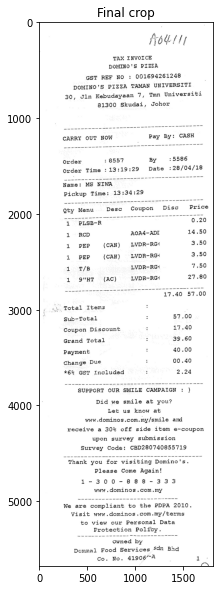

In [14]:
def implot(im, title, subplot=None, figsize=(10, 10)):
    '''
    Plot an image with given title using subplot or figsize.
    For debug purposes.
    '''
    if subplot is None:
        plt.figure(figsize=figsize)
    else:
        plt.subplot(*subplot)
    plt.title(title)
    plt.imshow(im, cmap="gray")

def extract_recibo(image, debug=False, i=0, border=50):
    '''
    Try to extract only recibo from scan with white borders.
    Uses adaptiveThreshold, morphology closing, medianblur, contour detection and 
    minimum bounding rectangle, from the opencv library.

    Visualized results in all training images, seems to work mostly fine. 
    Didn't check performance on test images.
    '''
    # Have a gray and rgb image.
    if len(image.shape) == 2:
        gray = image.copy()
        rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    else:
        rgb = image.copy()
        gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    # Adaptive threshold and median blur to remove small noises and have a binary image.
    t_image = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2).astype(np.int32)
    max_v = t_image.max()
    t_image = ((t_image*-1) + max_v).astype(np.uint8)
    t_image = cv2.medianBlur(t_image, 5)
    
    # Calculate border with morphology, to avoid black scan border artifacts.
    b_image = t_image - cv2.erode(t_image, np.ones((11, 11),np.uint8))  # border image

    # Close border image with a big kernel
    c_image = cv2.morphologyEx(b_image, cv2.MORPH_CLOSE, np.ones((200, 200),np.uint8))  # close borders
    
    # Find i contour of closed image
    contours, _ = cv2.findContours(c_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = sorted(contours, key=cv2.contourArea, reverse=True)[i]

    # Get minimum bounding rect of contour
    rect = cv2.boundingRect(contour)
    
    # Debug drawings and plots to visualize processing
    if debug:
        display = rgb.copy()
        cv2.rectangle(display, (int(rect[0]), int(rect[1])), (int(rect[0]+rect[2]), int(rect[1]+rect[3])), (0, 255, 255), 10)
        
        # Display intermediate results
        plt.figure(figsize=(50, 10))
        implot(gray, "Original", (1, 5, 1))
        implot(t_image, "Median, adaptive threshold", (1, 5, 2))
        implot(b_image, "Median, adaptive threshold, erosion border", (1, 5, 3))
        implot(c_image, "Median, adaptive threshold, erosion border, close", (1, 5, 4))
        implot(display, "Final result over original", (1, 5, 5))

    # Add border space
    x, y, w, h = rect
    x -= border
    y -= border
    w += border*2
    h += border*2
    
    # Define topleft and bottom right, check for out of bounds
    tl = [y, x]
    br = [y + h, x + w]
    if tl[0] < 0: tl[0] = 0
    if tl[1] < 0: tl[1] = 0
    if br[0] >= gray.shape[0]: br[0] = gray.shape[0] - 1
    if br[1] >= gray.shape[1]: br[1] = gray.shape[1] - 1
    
    # Check ratios for incorrect boxes
    area_ratio = h*w/(gray.shape[0]*gray.shape[1])
    w_h_ratio = min(w, h)/max(w, h)
    
    if debug: print(f"Area Ratio: {area_ratio}\nWidth Height Ratio: {w_h_ratio}")
    
    # Check edge cases, last resort return original image.
    if w_h_ratio < 0.2:  # If h is very different from w, recursively take next largest contour
        return extract_recibo(image, debug=debug, i=i+1)
    elif area_ratio < 0.03:  # If crop is too excessive (probably took a very small part), return original image.
        
        return rgb
    else:
        # Return cropped RGB image.
        # print(tl[1])
        # print(br[1])
        if (int(br[0]) > 1.5*tl[0]):
          return rgb[tl[0]:int(br[0]), tl[1]:br[1]]
        else:  
          return rgb[tl[0]:int(br[0]), tl[1]:br[1]]

plt.show()
train_sample = cv2.imread('train/X51006414712.jpg')
implot(extract_recibo(train_sample, debug=True), title="Final crop")
plt.show()


In [15]:
# MODES = ["train", "test"]
MODES = ["output/train", "output/val", "test"]

class OCR_DATA(Dataset):
    '''
    Abstração do MSCOCO com 5 captions por imagem. 
    '''
    def __init__(self, mode, seq_len, TOKENIZER, N_augment=1, width=300, height=400, image_transform=Compose([transforms.ToTensor(), Lambda(lambda img: img * 2.0 - 1.0)])):
      '''
      mode: um de "train", test".
      seq_len: tamanho máximo de sequência. 64 padrão para alinhar com feature 8x8 da efficientnet.
      transform: transformadas para serem aplicadas somente na imagem.
      '''
      assert mode in MODES
      self.mode = mode
      self.seq_len = seq_len
      self.N_augment = N_augment

      self.image_transform = image_transform
      self.TOKENIZER = TOKENIZER

      self.reshape_trans = transforms.Compose([transforms.ToPILImage(), transforms.Resize((height, width))])  
      
      txt_files = glob.glob(f"{mode}/*.txt")
      self.targets = list()
      self.images = list()
      for txt_file in txt_files:
        self.images.append(txt_file[:-4]+'.jpg')
        with open(txt_file, 'r') as target_file:
          self.targets.append(json.load(target_file))

      if (self.mode == "output/train" and self.N_augment>1):
        new_images = list()
        new_targets = list()
        for i in range(len(self.images)):
            new_images.extend(self.N_augment*[self.images[i]])
            new_targets.extend(self.N_augment*[self.targets[i]])
        self.images = new_images
        self.targets = new_targets   

      self.len = len(self.targets)  


    def __len__(self):
      return self.len

    def __getitem__(self, i):
        '''
        Imagens são extraídas do H5PY, convertidas para o formato [H, W, C], float32.
        Transformadas padrão são normalização para efficientnet com advprop e totensor.
        Frase original também é retornada para cálculo do bleu.
        '''
        
        caption = self.targets[i]

        caption_company = caption["company"]
        
        cap_key = caption.get("address")
        if cap_key:
          caption_address = caption["address"]
        else:
          caption_address = " "
        
        caption = caption_company + " [NL] " + caption_address


        target = self.TOKENIZER.encode(caption,
                                        padding='max_length',
                                        truncation=True,
                                        max_length=self.seq_len,
                                        return_tensors='pt')[0]                          

        im_bgr = cv2.imread(self.images[i])
        im_rgb = cv2.cvtColor(im_bgr, cv2.COLOR_BGR2RGB)

        im_rgb = extract_recibo(im_rgb, debug=False)
        image = self.reshape_trans(im_rgb)
        
        if self.image_transform is not None:
          image = self.image_transform(image).detach().float()

        return image, caption, target

    def get_dataloader(self, batch_size, shuffle, num_workers=4):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle, pin_memory=True, num_workers=num_workers)

In [16]:
N_augmentation = 10

train_transforms = Compose(
    [transforms.ColorJitter(0.15,0.1,0.2,0.1),
     transforms.RandomRotation(10),
     transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

test_transforms = Compose(
    [transforms.ToTensor(),
     Lambda(lambda img: 2.0*(img - 1.0))])

datasets = {"output/train": OCR_DATA("output/train", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, N_augment=N_augmentation, image_transform=train_transforms),
            "output/val": OCR_DATA("output/val", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms),
            "test": OCR_DATA("test", seq_len=hparams['seq_len'], TOKENIZER=TOKENIZER, image_transform=test_transforms)}

## Dados sobre uma amostra do dataset

max image tensor(-0.0549)
min image tensor(-2.)
Image shape: torch.Size([3, 400, 300])
Image .transpose(1, 2, 0) shape: (400, 300, 3)
company: RELAIS TOTAL OULMES [NL] AUTOROUTE RABAT MEKNES 15000 KHEMISSET
target: tensor([  391,  3577, 25018,  3001, 16359,   411,  4254, 22759,   784, 18207,
          908, 29846,  4630, 25002,   391, 23719,   382,  7934,   439, 16560,
          627,  2313,   480,  6021, 28580, 20788,     1,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


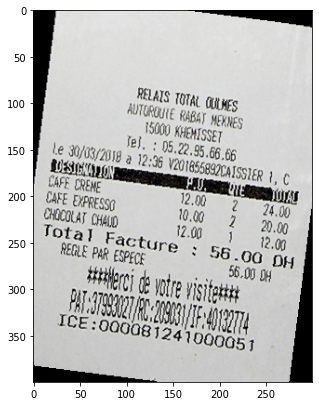

In [17]:
image = datasets["output/train"][2][0]
print('max image', image.max())
print('min image', image.min())
print('Image shape:', image.shape)
print('Image .transpose(1, 2, 0) shape:', image.cpu().numpy().transpose(1, 2, 0).shape)


plt.figure(figsize=(5, 10))
plt.imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))

company = datasets["output/train"][2][1]
print('company:', company)

target = datasets["output/train"][2][2]
print('target:', target)

## Representação das mesma imagem que foram augmentadas 5x

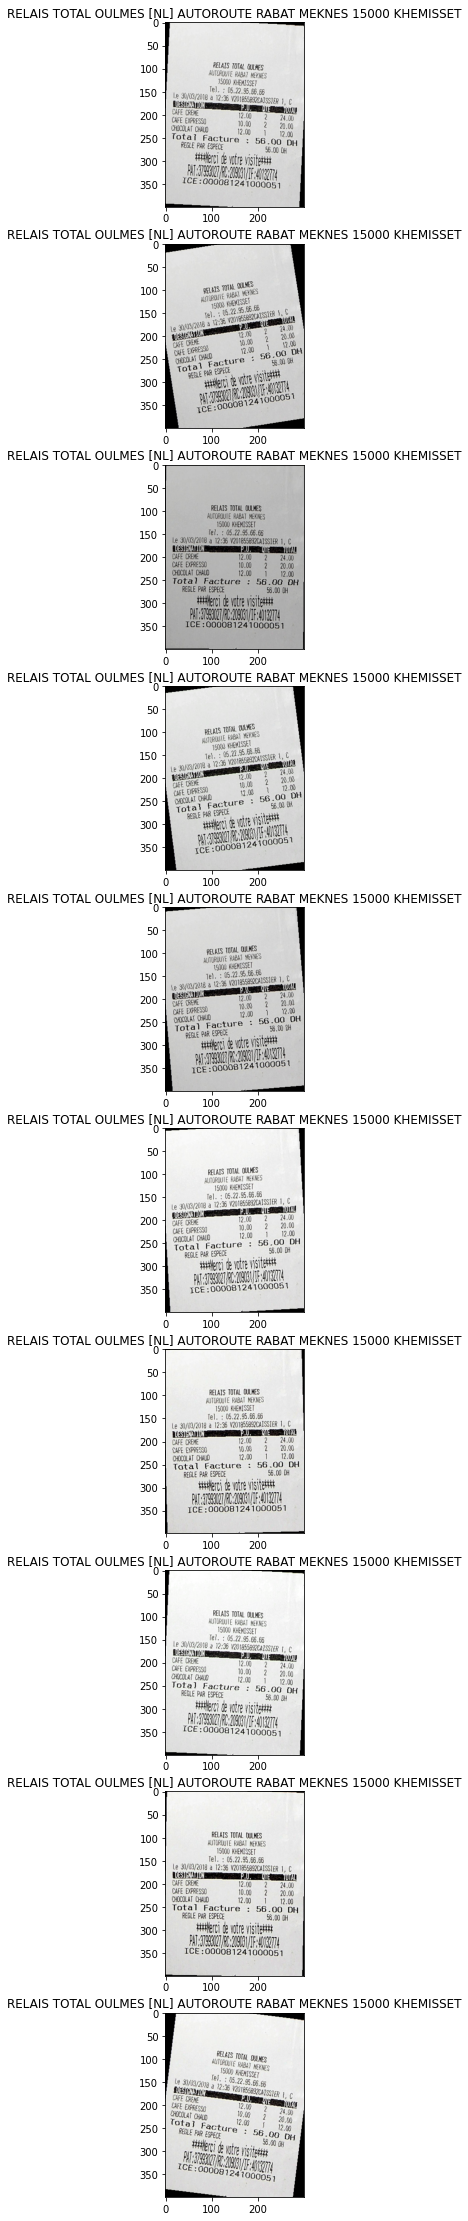

In [18]:
if N_augmentation>1:
  fig, axs = plt.subplots(N_augmentation, 1, figsize=(10, 40))
  for i in range(N_augmentation):
    image = datasets["output/train"][i][0]
    company = datasets["output/train"][i][1]
    axs[i].set_title(company)
    axs[i].imshow(((image.cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

In [19]:
dataset_lens = {mode: len(datasets[mode]) for mode in MODES}

In [20]:
print(f"Lens: {dataset_lens}")

Lens: {'output/train': 3190, 'output/val': 107, 'test': 200}


798
Train batch
torch.Size([3, 400, 300])
Company: WESTERN EASTERN STATIONERY SDN. BHD [NL] 42-46, JLN SULTAN AZLAN SHAH 51200 KUALA LUMPUR ; target: tensor([  549,  6038, 25992,   262, 12510, 25992,  5097,  8015,  3316,   476,
          180, 12145,     5,   272, 11083,   784, 18207,   908,  6426,    18,
         4448,     6,   446,   434,   567,   180,  4254, 25950,     3, 10491,
        12303,     3, 19964,   566, 11696,  3632,     3, 18519, 23634,   301,
        28468,  5905,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


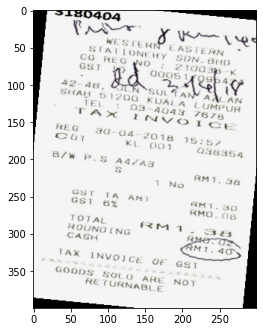

torch.Size([3, 400, 300])
Company: RESTORAN IBRAHIM MAJU SB [NL] NO.2, GROUND FLOOR, JALAN REKO SENTRAL 8 TAMAN REKO SENTRAL, 43000 KAJANG SELANGOR DE ; target: tensor([ 4083, 22633,  5033,    27, 22899,  7094,   329,  4800,   683,  1265,
        16757,   784, 18207,   908,  5693,     5,  4482,   350,  4630, 13110,
          377,  5017,  2990,     6,     3, 13853, 12303,  4083, 12725,   180,
         6431, 21415,   505,     3,  3221,  9312,  4083, 12725,   180,  6431,
        21415,     6,  8838,  2313,   480, 22356, 19775,     3, 23143, 19775,
         2990,  3396,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


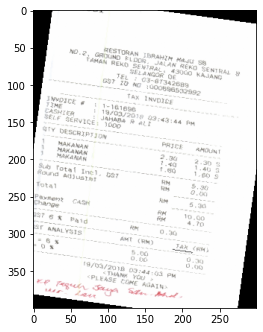

torch.Size([3, 400, 300])
Company: IKANO HANDEL SDN BHD [NL] NO 2A JALAN COCHRANE TAMAN MALURI 55100 KUALA LUMPUR ; target: tensor([   27, 12048,  7400,   454,  9853,  3577,   180, 12145,   272, 11083,
          784, 18207,   908,  5693,   204,   188,     3, 13853, 12303,  2847,
         8360, 16375,   427,     3,  3221,  9312,   283,  4090, 22182,  6897,
         2915,     3, 18519, 23634,   301, 28468,  5905,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


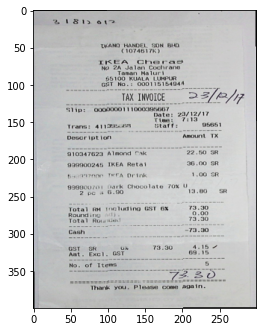

torch.Size([3, 400, 300])
Company: TRIPLE SIX POINT ENTERPRISE 666 [NL] NO 14 & 16 JALAN PERMAS 4/3 BANDAR BARU PERMAS JAY ; target: tensor([    3, 16840, 27872,  7933,     4,  9915, 13777, 13209,  5946, 15582,
         4132,   431,  3539,   784, 18207,   908,  5693,   968,     3,   184,
          898,     3, 13853, 12303,     3,  8742, 23010,   314, 14207,   272,
         9853,  4280,  8145,  8503,     3,  8742, 23010,   446, 15029,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


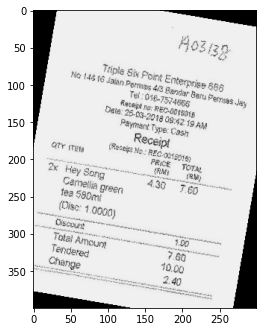

----------------------------------------
Test batch
Company: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR ; target: tensor([  549,  6038, 25992,   262, 12510, 25992,  5097,  8015,  3316,   476,
          180, 12145,     5,   272, 11083,   784, 18207,   908,  6426,    18,
         4448,     6,   446,   434,   567,   180,  4254, 25950,     3, 10491,
        12303,     3, 19964,   566, 11696,  3632,     3, 18519, 23634,   301,
        28468,  5905,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


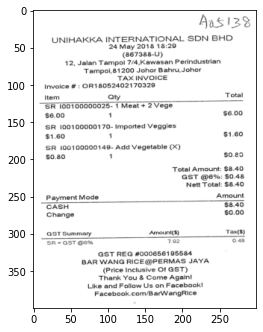

Company: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR ; target: tensor([ 4083, 22633,  5033,    27, 22899,  7094,   329,  4800,   683,  1265,
        16757,   784, 18207,   908,  5693,     5,  4482,   350,  4630, 13110,
          377,  5017,  2990,     6,     3, 13853, 12303,  4083, 12725,   180,
         6431, 21415,   505,     3,  3221,  9312,  4083, 12725,   180,  6431,
        21415,     6,  8838,  2313,   480, 22356, 19775,     3, 23143, 19775,
         2990,  3396,     1,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


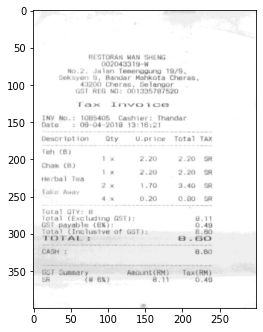

Company: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR ; target: tensor([   27, 12048,  7400,   454,  9853,  3577,   180, 12145,   272, 11083,
          784, 18207,   908,  5693,   204,   188,     3, 13853, 12303,  2847,
         8360, 16375,   427,     3,  3221,  9312,   283,  4090, 22182,  6897,
         2915,     3, 18519, 23634,   301, 28468,  5905,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


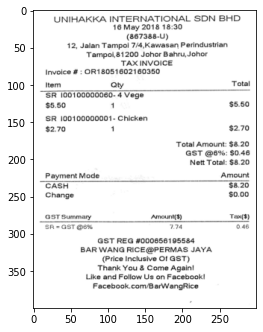

Company: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM, ; target: tensor([    3, 16840, 27872,  7933,     4,  9915, 13777, 13209,  5946, 15582,
         4132,   431,  3539,   784, 18207,   908,  5693,   968,     3,   184,
          898,     3, 13853, 12303,     3,  8742, 23010,   314, 14207,   272,
         9853,  4280,  8145,  8503,     3,  8742, 23010,   446, 15029,     1,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


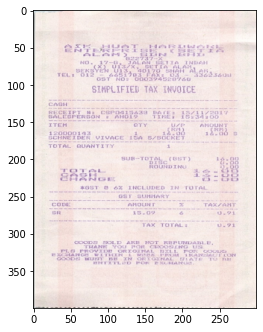

In [21]:
display_dataloaders = {mode: datasets[mode].get_dataloader(batch_size=4, shuffle=True) for mode in MODES}

print(len(display_dataloaders["output/train"]))

# Test-load batchs 
train_batch, test_batch = next(iter(display_dataloaders["output/train"])), next(iter(display_dataloaders["test"]))

print("Train batch")
for image, company, target in zip(train_batch[0], train_batch[1], train_batch[2]):
  print(image.shape)
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()  
print('----------------------------------------')

print("Test batch")
for image, company, target in zip(test_batch[0], test_batch[1], train_batch[2]):
  plt.figure(figsize=(4, 10))
  print(f"Company: {company}", f"; target: {target}")
  plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
  plt.show()

## Métricas

Usar as funções abaixo para calcular as métricas (exact match e F1):

In [22]:
import collections

def normalize_answer(s):
    """Lower text and remove extra whitespace."""

    def white_space_fix(text):
        return ' '.join(text.split())

    def lower(text):
        return text.lower()

    return white_space_fix(lower(s))

def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))

def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

# Definir a classe do modelo usado EfficientT5

In [23]:
"""
Code borrowed with thanks from:
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
https://gist.github.com/halochou/acbd669af86ecb8f988325084ba7a749
"""

import torch.nn as nn
import torch


class ConvGRUCell(nn.Module):
    """
    Basic CGRU cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvGRUCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        self.update_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                     kernel_size=self.kernel_size, padding=self.padding,
                                     bias=self.bias)
        self.reset_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                    kernel_size=self.kernel_size, padding=self.padding,
                                    bias=self.bias)

        self.out_gate = nn.Conv2d(in_channels=self.input_dim+self.hidden_dim, out_channels=self.hidden_dim,
                                  kernel_size=self.kernel_size, padding=self.padding,
                                  bias=self.bias)

    def forward(self, input_tensor, cur_state):

        h_cur = cur_state
        # data size is [batch, channel, height, width]
        x_in = torch.cat([input_tensor, h_cur], dim=1)
        update = torch.sigmoid(self.update_gate(x_in))
        reset = torch.sigmoid(self.reset_gate(x_in))
        x_out = torch.tanh(self.out_gate(torch.cat([input_tensor, h_cur * reset], dim=1)))
        h_new = h_cur * (1 - update) + x_out * update

        return h_new

    def init_hidden(self, b, h, w):
        return torch.zeros(b, self.hidden_dim, h, w).cuda()


class ConvGRU(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvGRU, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvGRUCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvGRU
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append(h)

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBGRU(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBGRU, self).__init__()
        self.forward_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvGRU(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)

    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CGRU layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CGRU layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)

        return ycat


In [24]:
"""
Code borrowed with thanks from:
Shreyas Padhy, and Andrea Palazzi
https://github.com/ndrplz/ConvLSTM_pytorch
https://github.com/shreyaspadhy/UNet-Zoo/blob/master/CLSTM.py
"""

import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):
    """
    Basic CLSTM cell.
    """

    def __init__(self, in_channels, hidden_channels, kernel_size, bias):

        super(ConvLSTMCell, self).__init__()

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1) 
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, b, h, w):
        return (torch.zeros(b, self.hidden_dim, h, w).cuda(),
                torch.zeros(b, self.hidden_dim, h, w).cuda())


class ConvLSTM(nn.Module):

    def __init__(self, in_channels, hidden_channels, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_channels = self._extend_for_multilayer(hidden_channels, num_layers)
        if not len(kernel_size) == len(hidden_channels) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim  = in_channels
        self.hidden_dim = hidden_channels
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i-1]

            cell_list.append(ConvLSTMCell(in_channels=cur_input_dim,
                                          hidden_channels=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """
        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful
        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            b, _, _, h, w = input_tensor.shape
            hidden_state = self._init_hidden(b, h, w)

        layer_output_list = []
        last_state_list   = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):

                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, b, h, w):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(b, h, w))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                    (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class ConvBLSTM(nn.Module):
    # Constructor
    def __init__(self, in_channels, hidden_channels,
                 kernel_size, num_layers, bias=True, batch_first=False):

        super(ConvBLSTM, self).__init__()
        self.forward_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        self.reverse_net = ConvLSTM(in_channels, hidden_channels//2, kernel_size,
                                    num_layers, batch_first=batch_first, bias=bias)
        
    def forward(self, xforward, xreverse):
        """
        xforward, xreverse = B T C H W tensors.
        """

        y_out_fwd, _ = self.forward_net(xforward)
        y_out_rev, _ = self.reverse_net(xreverse)

        y_out_fwd = y_out_fwd[-1] # outputs of last CLSTM layer = B, T, C, H, W
        y_out_rev = y_out_rev[-1] # outputs of last CLSTM layer = B, T, C, H, W

        reversed_idx = list(reversed(range(y_out_rev.shape[1])))
        y_out_rev = y_out_rev[:, reversed_idx, ...] # reverse temporal outputs.
        ycat = torch.cat((y_out_fwd, y_out_rev), dim=2)
        
        return ycat

In [25]:
def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm2d') != -1:
        print('freezing ', m)
        m.eval()

In [26]:
class EfficientT5(pl.LightningModule):

    def __init__(self, params):
        super(EfficientT5, self).__init__()

        self.params = params
        
        override_params = {'dropout_rate':params['dropout_rate'],'drop_connect_rate':params['drop_connect_rate']}

        # Features da efficient net atuarão como as features do encoder do T5
        self.encoder = EfficientNet.from_pretrained(params['enet'], advprop=True, **override_params)
        # freeze BN
        self.encoder = self.encoder.apply(set_bn_eval)
        
        # freeze efficientnet (encoder)
        for param in self.encoder.parameters():
          param.requires_grad = False
        
        self.decoder = T5ForConditionalGeneration.from_pretrained(params['t5'])
        # freeze t5 (decoder)
        for param in self.decoder.parameters():
          param.requires_grad = False
        
        self.bridge = ConvGRU(in_channels=int(112/2), hidden_channels=self.decoder.config.d_model, kernel_size=(3, 3), num_layers=1, batch_first=True)
        self.tokenizer = TOKENIZER

    def _get_efn_embeddings(self, images):

        # Shape (N, 112, 16, 16)
        # features = self.encoder.extract_features(images)
        features = self.encoder.extract_endpoints(images)["reduction_4"]
        # print('features shape', features.shape)

        features = features.unsqueeze(1)

        
        # features = features.reshape(features.shape[0], 1, 112, 25, 19) #best

        features = features.reshape(features.shape[0], 2, int(112/2), 25, 19)

        # Shape: (N, 512, -, -)
        features, last_state_list = self.bridge(features)
        
        features = features[0]

        # Shape: (N, -1, 512) -> Pra ficar do shape de entrada do decoder que é (N, seq_len, d_model)
        efn_embeddings = features \
            .permute(0, 1, 3, 4, 2) \
            .reshape(features.shape[0], -1, self.decoder.config.d_model)

        return efn_embeddings

    
    def _generate_tokens(self, efn_embeddings):
        '''
        Token generation
        '''
        max_length = self.params['seq_len']

        # Add start of sequence token
        decoded_ids = torch.full((efn_embeddings.shape[0], 1),
                                 self.decoder.config.decoder_start_token_id,
                                 dtype=torch.long).to(efn_embeddings.device)
        
        encoder_hidden_states = self.decoder.get_encoder()(inputs_embeds=efn_embeddings)

        for step in range(max_length-1):
            logits = self.decoder(decoder_input_ids=decoded_ids,
                                  encoder_outputs=encoder_hidden_states)[0]
            next_token_logits = logits[:, -1, :]

            # decoding
            next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
            
            # Check if output is end of senquence for all batches
            if torch.eq(next_token_id[:, -1], self.tokenizer.eos_token_id).all():
                break

            # Concatenate past ids with new id, keeping batch dimension
            decoded_ids = torch.cat([decoded_ids, next_token_id], dim=-1)

        return decoded_ids

    def forward(self, batch): # TODO pro futuro: colocar os dados necessários individualmente e não o batch inteiro
        # Aqui os labels são strings e os tokens são os labels a serem inseridos no decoder
        # print(len(batch))
        images, label, token = batch

        # Output do efn atua como embedding do encoder
        efn_embeddings = self._get_efn_embeddings(images)
        # print('efn_embeddings', efn_embeddings.shape)

        if self.training:
            outputs = self.decoder(inputs_embeds=efn_embeddings,
                                   decoder_input_ids=None, 
                                   labels=token,
                                   return_dict=True)
            return outputs.loss
        else:
            return self._generate_tokens(efn_embeddings)

    def training_step(self, batch, batch_idx): 
        loss = self(batch)
        self.log('loss', loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        val_loss = outputs.loss.detach().cpu().numpy()

        return {"val_loss": val_loss, "pred": decoded_pred, "target": batch[1]}

    def test_step(self, batch, batch_idx):
        pred_tokens = self(batch)
        # Tokens -> String
        decoded_pred = [self.tokenizer.decode(tokens) for tokens in pred_tokens]
        
        images, label, token = batch

        efn_embeddings = self._get_efn_embeddings(images)

        outputs = self.decoder(inputs_embeds=efn_embeddings,
                                decoder_input_ids=None, 
                                labels=token,
                                return_dict=True)

        test_loss = outputs.loss.detach().cpu().numpy()

        return {"test_loss": test_loss, "pred": decoded_pred, "target": batch[1]}


    def validation_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        # n = random.choice(range(len(trues)))
        n_samples = random.sample(range(len(trues)), 1)
        for n in n_samples:
            print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")
        
        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        val_loss = sum([x['val_loss'] for x in outputs])/len(outputs)

        self.log("val_loss", val_loss, prog_bar=True)

        self.log("val_bleu_score", bleu.score, prog_bar=True)
        self.log("val_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("val_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("val_f1", f1, prog_bar=True)
        self.log("val_exact", exact, prog_bar=True)

        return {'val_f1': f1, 'val_loss': val_loss}

    def test_epoch_end(self, outputs):
        # Flatten dos targets e preds para arrays
        trues = sum([list(x['target']) for x in outputs], [])
        preds = sum([list(x['pred']) for x in outputs], [])

        n = random.choice(range(len(trues)))
        print(f"\nSample Target: {trues[n]}\nPrediction: {preds[n]}\n")

        f1 = []
        exact = []
        for true, pred in zip(trues, preds):
            f1.append(compute_f1(a_gold=true, a_pred=pred))
            exact.append(compute_exact(a_gold=true, a_pred=pred))
        f1 = np.mean(f1)
        exact = np.mean(exact)

        bleu = sacrebleu.corpus_bleu(preds, [trues])

        test_loss = sum([x['test_loss'] for x in outputs])/len(outputs)
        
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_bleu_score", bleu.score, prog_bar=True)
        self.log("test_bleu_1", bleu.precisions[0], prog_bar=True)
        self.log("test_bleu_4", bleu.precisions[3], prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)
        self.log("test_exact", exact, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = adafactor.Adafactor(self.parameters(), weight_decay=0.001)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_loss'}
    
    def train_dataloader(self):
        return datasets["output/train"].get_dataloader(batch_size=self.params['bs'], shuffle=True)
    def val_dataloader(self):
        return datasets["output/val"].get_dataloader(batch_size=self.params['bs'], shuffle=False)    
    def test_dataloader(self):
        return datasets["test"].get_dataloader(batch_size=self.params['bs'], shuffle=False)

# Definir os hiper-parametros do modelo
## Diversos hiper-parametros foram testados, mas os melhores valores foram obtidos com os parametros abaixo 


**Os parâmetros de *dropout_rate* e *drop_connect_rate* da efficient-net são bastante interessantes podendo dar um maior domínio sobre a efficiente-net**

In [27]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYzJiZGU4NWMtZDI0NS00ZjIxLWIwZmMtZDI1ZTJjMTg3MjE4In0=",
    project_name="orllem/ocr-recibos-fine-tuning-augment-newvalidation",
    params=hparams)

https://ui.neptune.ai/orllem/ocr-recibos-fine-tuning-augment-newvalidation/e/OC-19


NeptuneLogger will work in online mode


In [28]:

# Initialize Lightning Module with parameters defined above.
# model = EfficientT5(hparams)
pre_model = "drive/My Drive/aula13_checkpoints_drive/cloud_reduced_part_final_netupne_adafactor_gpu_model-epoch=7-step=10679.ckpt"
model = EfficientT5(hparams).load_from_checkpoint(pre_model, params=hparams)
print(model)

# Configure callbacks
if hparams["debug"]:
  checkpoint_callback = None
  logger = None
  early_stop_callback = None
else:
  checkpoint_path = 'drive/My Drive/aula13_checkpoints_drive/epoch=10.ckpt'
  checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
  print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
  print(f'Saving checkpoints to {checkpoint_dir}')
  checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                      filepath=checkpoint_dir,
                                                      save_top_k=1, 
                                                      monitor="val_loss", mode="min")
  early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=hparams["patience"], mode='min')

trainer = pl.Trainer(gpus=1,
                     fast_dev_run=hparams["debug"],
                     accumulate_grad_batches=hparams["accum"],
                     logger=neptune_logger,
                     checkpoint_callback=checkpoint_callback, 
                     callbacks=[early_stop_callback],
                     max_epochs=hparams["max_epochs"])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/adv-efficientnet-b0-b64d5a18.pth" to /root/.cache/torch/hub/checkpoints/adv-efficientnet-b0-b64d5a18.pth



Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_


Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: Checkpoint directory /content/drive/My Drive/aula13_checkpoints_drive exists and is not empty.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


EfficientT5(
  (encoder): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_

In [29]:
trainer.fit(model)


  | Name    | Type                       | Params
-------------------------------------------------------
0 | encoder | EfficientNet               | 5.3 M 
1 | decoder | T5ForConditionalGeneration | 60.5 M
2 | bridge  | ConvGRU                    | 7.9 M 
-------------------------------------------------------
7.9 M     Trainable params
65.8 M    Non-trainable params
73.6 M    Total params



Sample Target: GUARDIAN HEALTH AND BEAUTY SDN BHD [NL] LOT F/L2A.4, LEVEL 2A FIRST WORLD PLAZA, FIRST WORLD
Prediction: a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a 



/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The validation_epoch_end should not return anything as of 9.1. To log, use self.log(...) or self.write(...) directly in the LightningModule
  warnings.warn(*args, **kwargs)



Sample Target: RSTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: MR. STENNAN WALKER SCHULBERG W. MR.C. JA MR. SCHULBERG, MR. DR. SCHULBERG, MR. SCHULBERG, MR. SCHULBERG,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: ASIA MART [NL] NO.23 BATU 10, TAMAN SENTOSA, JALAN KAPAR, 42200 KLANG, SELANGOR.
Prediction: JANUARY RES PHILIP MORRIS MANAGEMENT RESEARCH CENTER ______________________________________



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 33198, BATU 4 JALAN KAPAR, MUKIM KAPAR 42100 KLANG, SELANGOR 1605-TMN SRI BINTANG
Prediction: MR JONES MARRY (C) SUN BHD [M] LOT, JANUARY, MARCH, JANUARY, JANUARY, JULY, JULY, JULY, JULY, JULY, JULY



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8. JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSIA
Prediction: MONTHLY BUDGET (M) SSN BHD [M] _____________________________________________



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: PERNIAGAAN RIANG RIA [NL] NO7,JLN UERO,SHAH ALAM.
Prediction: PRESS SERVICE SUH BHD [NL] __________________________________________________



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: ASIA MART [NL] NO.23 BATU 10, TAMAN SENTOSA, JALAN KAPAR, 42200 KLANG, SELANGOR.
Prediction: JANUARY RESEARCH JUNE RES [NC] 102,140 HALFORD SCHOO HALFORD RESEARCH ssoss ssosssssssssssssssssss



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA
Prediction: 98 STOCK MART STO STOCK NO. 117 P.T. 5811, JALAL BRUSSEL, THAMAN BERGERLY 41100 HAMAL SCHULLER 11380 FLEONG BERGER



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: CARREFOUR RESTAURANT [NL] 18,JALAN PERMAS 10/7 BANDAR BARU PERMAS JAYA, MASAI,JOHOR
Prediction: AMERICAN PRESENTATION SDN BHD [NL] NO. 145 AIR PRESENT 530 HARMON BALL PRESENTARAR, HARMON BALL PRESENTARAR, HARMON BALL PRESENTARAR, HARMON B



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARBOR RARISZEZE (KL) SDN BHD [NL] LOT 3, JALAN PELBOUR 2/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1245-DESA SRI HARTAMAS
Prediction: 99 STOCK MART S/B BHD [NL] LOT P.T. 2811, JALUM ANGKA JANAN BERGERLY 41150 KLANG, SELANGOR 1155-PREE ST. SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: MR. D.I.Y. SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.I. (H) SDN BHD [NL] LOT 1851-51A & 1851-35A, JALIAN KUPK (PL, JALAN KUPK, & KARANIAN PRESENTATION BALANCE, 4



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GUARDIAN HEALTH AND BEAUTY SDN BHD [NL] LOT F/L2A.4, LEVEL 2A FIRST WORLD PLAZA, FIRST WORLD
Prediction: MR. JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN JALAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: ECO-SHOP MARKETING SDN BHD [NL] LOT F1-01, 6, JALAN 8/27A, SEKSYEN 5 WANGSA MAJU, 53300 KUALA LUMPUR, WILAYAH PERSEKUTUAN KUALA LUMPUR, MALAYSIA.
Prediction: NO. 93, D.M.T. JAMI WORKERS BY, STE. JAMI, STE. JAMI, STE. JAMI, STE. JAMI, STE. JAMI, STE. JAMI, 



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: PINGHWAI TRADING SDN BHD [NL] NO.2, JALAN METRO PERDANA TIMUR 11, KEPONG ENTERPRENUERS PARK, OFF JALAN KEPONG, 52100 KUALA LUMPUR.
Prediction: EVALUATION SYSTEMS SDN BHD [NL] NO. 5, JALAN MAY DIVARAR LINE J, HOUSEMAN ENTRYBURGAR FINAL



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: ANZEL ADVERTISING (M) SDN BHD [NL] UNIT G-5B, GROUND FLOOR, WISMA UOA II, NO 21, JALAN PINANG, 50450 KUALA LUMPUR, MALAYSIA
Prediction: MR. JALAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN JAAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Prediction: MR. D.J. (WALL) SDN BHD [NL] NO.21.A. & JAAN D. JALAN KIN, JALAN B. STEINSTEIN JALAN KIN, JALAN SCHNEIDER JA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: RESTAURANT SIN DU [NL] K3-113, JL IBRAHIM SULTAN 80300 JOHOR BAHRU JOHOR
Prediction: POPELLUMS SIN BHD [NL] NO EPA JAAN BERMAN PALMON KUMAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: SYARIKAT PERNIAGAAN GIN KEE [NL] NO 290, JALAN AIR PANAS, SETAPAK, 53200, KUALA LUMPUR.
Prediction: SYARIARIJ PERNIAGARA GIN KEE [NL] NO 290, JALAN AIR PAMAR, SETAPAK, 53200, KUALA LUMPUR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: AEON CO. (M) BHD [NL] 3RD FLR, AEON TAMAN MALURI SC JLN JEJAKA, TAMAN MALURI CHERAS, 55100 KUALA LUMPUR
Prediction: ADDED CO. (M) BHD [NL] 3RD FLR. ADDING TANAA MALURE SC LIN URRA TANAA MALURE GEORGIA DRIVE BALL LINFORM



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: ABC HO TRADING [NL] NO.2&4, JALAN HARMONI 3/2, TAMAN DESA HARMONI. 81100 JOHOR BAHRU JOHOR
Prediction: MONTHLY DATEATE [NL] NO.3 JALAN KUBBINC 2/L TAWAW ENR. KARAM KAKAAR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: CARREFOUR RESTAURANT [NL] 18,JALAN PERMAS 10/7 BANDAR BARU PERMAS JAYA, MASAI,JOHOR
Prediction: KATRIBUY PRESENTANT SDN BHD [NL] 10, LAAN KATRIBUBUAR 017, KATRIBUAR KATRIBUBUAR, HARVA,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: PERNIAGAAN RIANG RIA [NL] NO7,JLN UERO,SHAH ALAM.
Prediction: BAW SHARE BY BRAND BNL [NL] NO. JALAN HAMMER JALAN HAMMER



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: SYL ROASTED DELIGHTS SDN. BHD. [NL] 75. JALAN SS 22/19, DAMANSARA JAYA, 47400 PJ
Prediction: QUERIENT SYSTEM SHANG [NL] NO.16.65 (PPL) JALANAN JAJAA JAJA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: RESTAURANT SIN DU [NL] K3-113, JL IBRAHIM SULTAN 80300 JOHOR BAHRU JOHOR
Prediction: POPULATIONS SDN BHD [NL] NO. JA. HARRISON SHARON KARLARA KARLARA KARLARA KARLARA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: ADVANCO COMPANY [NL] NO 1&3, JALAN WANGSA DELIMA 12, WANGSA LINK, WANGSA MAJU, 53300 KUALA LUMPUR
Prediction: PANAMAMA PRESENTER / KURARA / KURARA / KURARA / KURARA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: ASO ELECTRICAL TRADING SDN BHD [NL] NO 31G, JALAN SEPADU C 25/C, SECTION 25, TAMAN INDUSTRIES, AXIS 40400 SHAH ALAM, SELANGOR.
Prediction: - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: LIGHTROOM GALLERY SDN BHD [NL] NO: 28, JALAN ASTANA 1C, BANDAR BUKIT RAJA, 41050 KLANG SELANGOR D.E, MALAYSIA
Prediction: MR. D.J. (M): SDN BHD [NL]: LOT 3, 4,4 JAJA JAJA JAJA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU
Prediction: PERINAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU
Prediction: PERINAJAA SERUM BINL [NL] NO.3D,JALAN PEUMAA 3/08 RAUM RAUM BRAUM



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1214-JINJANG UTARA
Prediction: 99 SPIED MART S/B [NL] LOT P.T. 211, JALAN AUGCA, TANAANA BERKELEY 41150 KLANG, SELANGOR 1515-TUM XXXXXXXXXXX



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: IKANO HANDEL SDN BHD [NL] NO 2A JALAN COCHRANE TAMAN MALURI 55100 KUALA LUMPUR
Prediction: LINDA HARRISSON SDN BHD [NL] NO 2A LALAN COLUMBIAK TANNA MAL101 5100 KUALA LAUNE



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: FIVE STAR CASH & CARRY [NL] G.23 & G.22, PLAZA SERI SETIA, NO.1 JALAN SS 9/1, 47300 PJ, SELANGOR.
Prediction: GEORGE KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KASS KA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: ECO-SHOP MARKETING SDN BHD [NL] LOT F1-01, 6, JALAN 8/27A, SEKSYEN 5 WANGSA MAJU, 53300 KUALA LUMPUR, WILAYAH PERSEKUTUAN KUALA LUMPUR, MALAYSIA.
Prediction: MR. SELLY SDN BHD [NL] 207,513,436 HALFANN JAJA JAJA JAJA JAJA JAJA JAJA JAJA JAJA JAJA JAJA JAJA JAJA JAJA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: RSTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Prediction: RETURNS HAIM SHANG (NL) NO.2, JALAN TIM UNE, SERIES KARO BARNER, JALAN



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GOLDEN ARCHES RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Prediction: GEORGE ALANLAN JAULING SDN BHD [NL] LOT 5, JANUARY 3A, DANNANGANG JAUL KOOL SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: POPULAR BOOK CO. (M) SDN BHD [NL] NO 8, JALAN 7/118B, DESA TUN RAZAK 56000 KUALA LUMPUR, MALAYSI.
Prediction: ROPER CRC. (M) SDN BHD [NL] NO 8, JALAN 7/18B, DISA TUN BALONG SHONG KUALA LUMPUR,



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1245-DESA SRI HARTAMAS
Prediction: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN AUGOL, TAMAN BERKELEY 41150 KLANG, SELANGOR 1130-TUM KLANG, SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: PERNIAGAAN ZHENG HUI [NL] NO.59 JALAN PERMAS 9/5 BANDAR BARU PERMAS JAYA 81750 JOHOR BAHRU
Prediction: PORNIAAAM TIMING [NL] NO.8. JALAN PEDWAR (NO. RADANG BALAN PEDWAR (NO. 6170200 RACON BREAKH



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GOLDEN ARCHES RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Prediction: GEORGE MASCHIAN PINKINSONSED SDN BHD [NL] LOT 5, BANQUERSS TA, BANQUERSRS UTDOWN MT, JALAN SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.
Prediction: GARDENIA BAKERIES (KL) SDN BHD [NL] LOT 3, JALAN PELABUR 23/1, 40300 SHAH ALAM, SELANGOR.



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: RESTORAN SIAM VILLAGE [NL] NO.8,JALAN PERMAS 10/7, PERMAS JAYA, 81750 JOHOR BAHRU.
Prediction: BERMUDA HEE SDN BHD [NL] NO.1A, JALAN RICHARD 2/1/



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: MENTAI INITIAL SDN BHD [NL] NO.37-1, PLAZA DANAU DESA 2, JALAN 109F, TAMAN DANAU DESA, 58100 KUALA LUMPUR.
Prediction: PHILIP MORRIS (NC) SDN BHD [NL] LOT 2474.84 XXX JAJA



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39, 47400 PETALING JAYA SELANGOR
Prediction: BERMUDA A. LA INGREDIENTS SDN BHD [NL] NO.2, JALAN SELLIN, CARAR PRIALL ING JAJA, SELANGOR



Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.


Sample Target: WAHIN HARDWARE SDN BHD [NL] 425, JALAN PAHANG, SETAPAK, 53000 KUALA LUMPUR.
Prediction: HARVARD HARVARD SDN BHD [NL] NO. 13, JALAN HAMANN, LYON LYON SHARON KATZ, JALAN,




Failed to send channel value.
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/channels/channels_values_sender.py", line 156, in _send_values
    self._experiment._send_channels_values(channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/experiments.py", line 1167, in _send_channels_values
    self._backend.send_channels_values(self, channels_with_values)
  File "/usr/local/lib/python3.6/dist-packages/neptune/utils.py", line 211, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/neptune/internal/backends/hosted_neptune_backend.py", line 571, in send_channels_values
    raise ChannelsValuesSendBatchError(experiment.id, batch_errors)
neptune.api_exceptions.ChannelsValuesSendBatchError: Received batch errors sending channels' values to experiment OC-19. Cause: Error(code=400, message='X-coordinates must be strictly increasing for channel: 773d3b71-69ed-4c95-8956-d67c71521479.

1

# Avaliação no Teste

In [30]:
test_dl = datasets["test"].get_dataloader(batch_size=32, shuffle=False, num_workers=4)

In [31]:
trainer.test(model, test_dl)


Sample Target: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Prediction: JIM CRAIG HALL SDN BHD [NL] NO. 15, JALAN SILVA SILVA SILVA SILVA SILVA SILVA SILVA SILVA SILVA SILVA


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_bleu_1': 56.15687992988607,
 'test_bleu_4': 33.20726172465961,
 'test_bleu_score': 34.7985515380509,
 'test_exact': 0.065,
 'test_f1': 0.3617156631527911,
 'test_loss': 2.3859321730477467}
--------------------------------------------------------------------------------


[{'test_bleu_1': 56.15687992988607,
  'test_bleu_4': 33.20726172465961,
  'test_bleu_score': 34.7985515380509,
  'test_exact': 0.065,
  'test_f1': 0.3617156631527911,
  'test_loss': 2.3859321730477467}]

# Resultados do melhor modelo no Teste (menor val_loss)

In [35]:
best_model = "drive/My Drive/aula13_checkpoints_drive/finetuning_augm_extract_app3_adafactor_seqred_test1-epoch=39-step=1799.ckpt"
test_model = EfficientT5(hparams).load_from_checkpoint(best_model, params=hparams).cuda().eval()

Loaded pretrained weights for efficientnet-b0
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(16, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(96, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(144, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
freezing  BatchNorm2d(24, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_s

In [37]:
trainer.test(test_model, test_dl)


Sample Target: FARMASI LIGAMAS [NL] NO. 47, JALAN MERANTI 1A, BANDAR BARU UTAMA, 44300 BATANG KALI, SELANGOR.
Prediction: KAWAII TRAAX [NL] NO. 15, JALAN KURA/JN BRAZIL KURA KURA


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_bleu_1': 53.99327448507776,
 'test_bleu_4': 30.60293057890944,
 'test_bleu_score': 34.47873767448549,
 'test_exact': 0.045,
 'test_f1': 0.3582145422329577,
 'test_loss': 2.3231155702045987}
--------------------------------------------------------------------------------


[{'test_bleu_1': 53.99327448507776,
  'test_bleu_4': 30.60293057890944,
  'test_bleu_score': 34.47873767448549,
  'test_exact': 0.045,
  'test_f1': 0.3582145422329577,
  'test_loss': 2.3231155702045987}]

# Aplicação do modelo em alguns caso do Teste

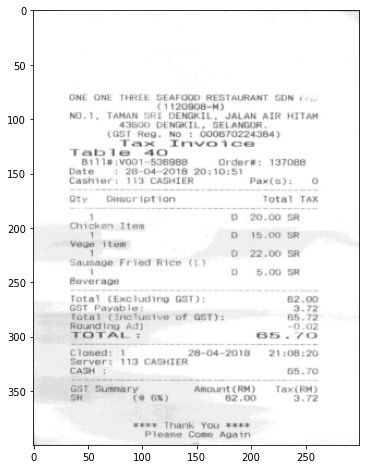

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO.1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: GEORGE MART J STRONG SDN BHD [NL] NO.1 JALAN JER ENGLAND, JALAN JULI, STANDARD, JALAN JULI, STANDARD, JALAN



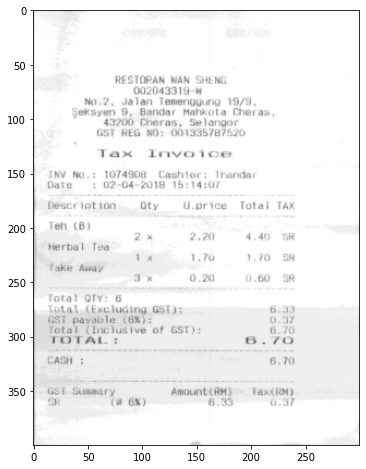

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNE 19/9, SENIKKYN 9, BANGAR MAHHA CHERAR, 43200 CHERAR, SELANGOR



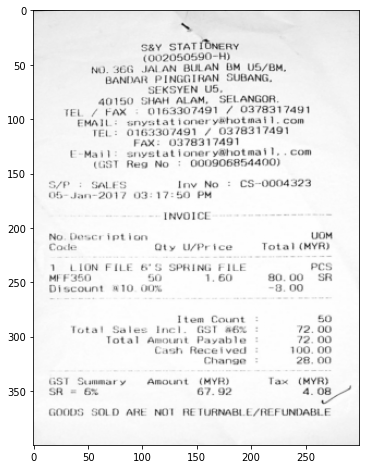

Labels: S&Y STATIONERY [NL] NO. 36G JALAN BULAN BM U5/BM, BANDAR PINGGIRAN SUBANG, SEKSYEN U5, 40150 SHAH ALAM, SELANGOR.
Pred: SAW STATEMENTS [NL] NO. 3400, JAALAN BALANCE BM UPDA, BANDAR FRANCHISON SUNANG, SECOND UR 12, 45100 SHAK ALAM, SELANGOR.



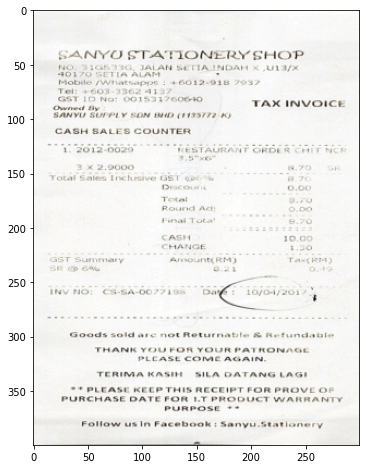

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: ANALYSIS CONTINUOUS SDN BHD [NL] NO. JALAN BETUS JATIN BOSTON, JALAN BOSTON, BOSTON, BOSTON, BOSTON, BOSTON, BLAIAN, BLAIAN,



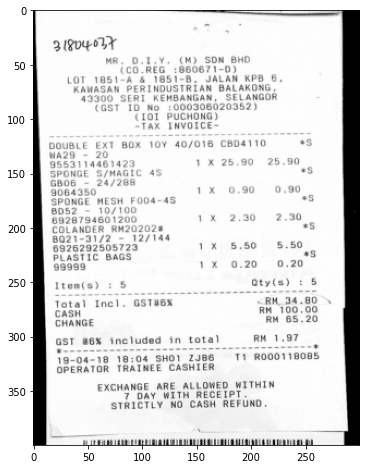

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: BREAK D.I.T. (M) SDN BHD [NL] LOT 1881-A & 1881-S, LANK KP 6, KAWASAN PERINDUSTRIA BLAKONG, 43300 SERI KEMBANGAN.



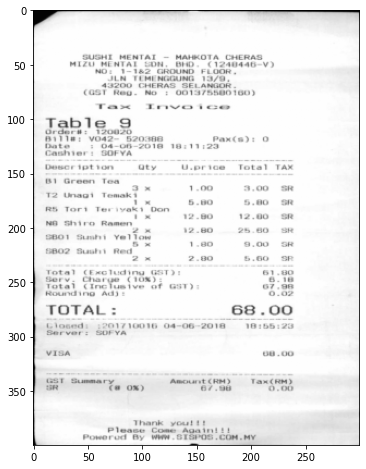

Labels: MIZU MENTAI SDN. BHD. [NL] NO: 1-1&2 GROUND FLOOR, JLN TEMENGGUNG 13/9, 43200 CHERAS SELANGOR.
Pred: KEY RESEARCH SDN, BHD, [NL] NO. 15, JANUARY FLA, JA



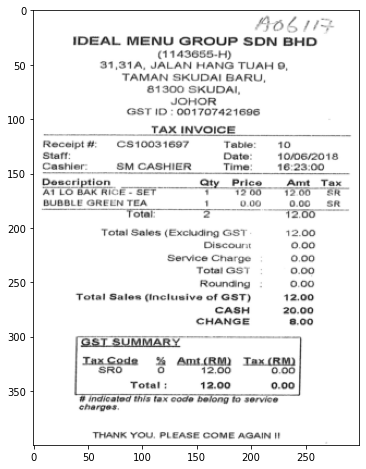

Labels: IDEAL MENU GROUP SDN BHD [NL] 31,31A, JALAN HANG TUAH 9, TAMAN SKUDAI BARU, 81300 SKUDAI, JOHOR
Pred: PINAL MARKET DRUGUG [NL] 83 206, JALAN JALAN TRAINE TRAINE XTRA400 DEAX TAXAR KARAN



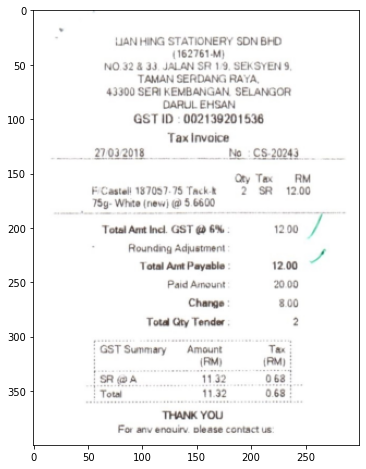

Labels: LIAN HING STATIONERY SDN BHD [NL] NO.32 & 33, JALAN SR 1/9, SEKSYEN 9, TAMAN SERDANG RAYA, 43300 SERI KEMBANGAN, SELANGOR DARUL EHSAN
Pred: LUAN HONG STATIONERY SDN BHD [NL] NO.53 & 131, JALAN SB 1/9, SEDUCTION, 3,000 ARKANS BERGANG DALAN, 41300 SURE RICHMOND, SELANGOR



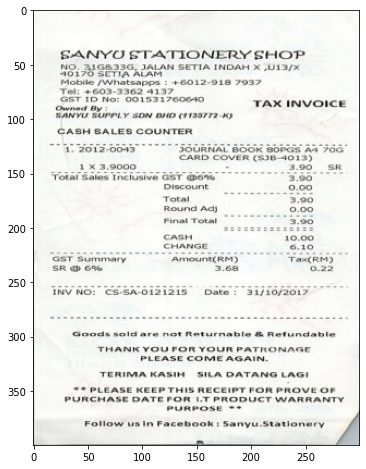

Labels: SANYU STATIONERY SHOP [NL] NO. 31G&33G, JALAN SETIA INDAH X ,U13/X 40170 SETIA ALAM
Pred: KONG JOAN CRAIGNE SDN BHD [NL] NO. JALAN BERMAN JOAN BERMAN JOAN BERMAN JOAN BERMAN JAAN BERMAN JAAN BERMAN JAAN BERMAN JAAN



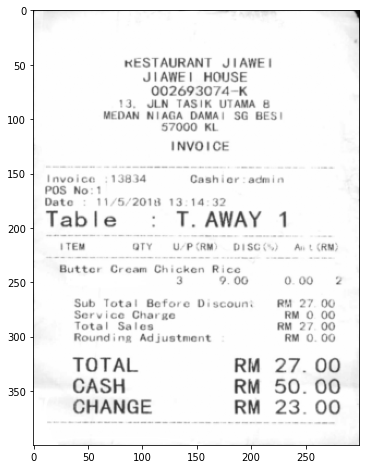

Labels: RESTAURANT JIAWEI JIAWEI HOUSE [NL] 13, JLN TASIK UTAMA 8 MEDAN NIAGA DAMAI SG BESI 57000 KL
Pred: MEMO PANE JANES [NL] NO 3, JANES JANES JANES



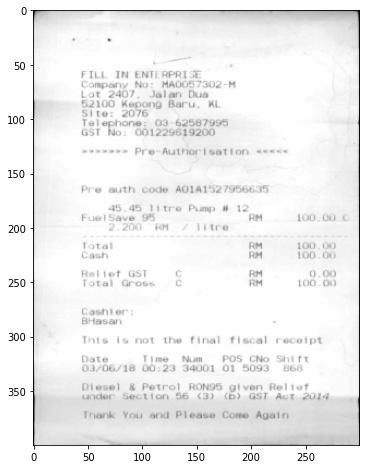

Labels: FILL IN ENTERPRISE [NL] LOT 2407, JALAN DUA 52100 KEPONG BARU, KL
Pred: C-105 BROTHERS SDN BHD [NL] NO.3 PLPL. JALAN, 57140 BRIAN, KAKA, 61180 SELANGOR



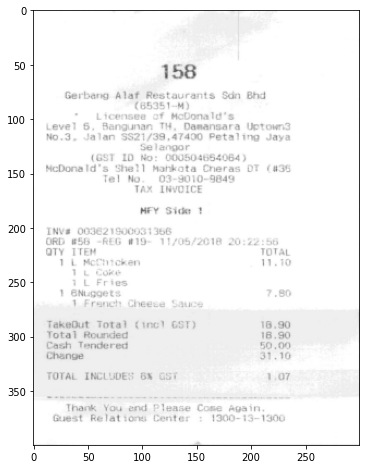

Labels: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Pred: GERBAND ALAN BREININGER SDN BHD [NL] LOT, & BRENNAN TA, DOWNANA UPPRESS, SLANG SELANGOR



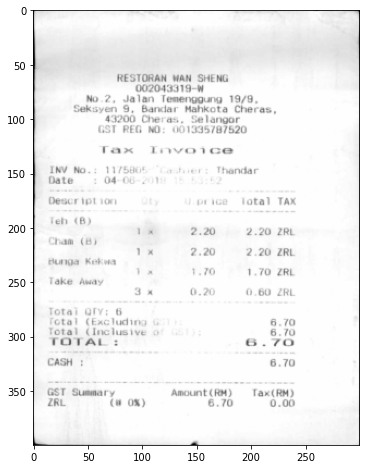

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNE 19/9, SEKKATHN 9, BANDAR MAHWOTA CHASE, 43200 CHASE, SELANGOR



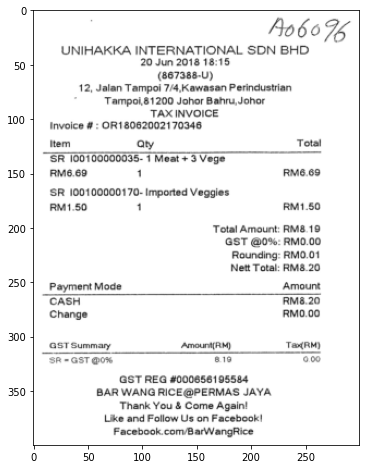

Labels: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU, JOHOR
Pred: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



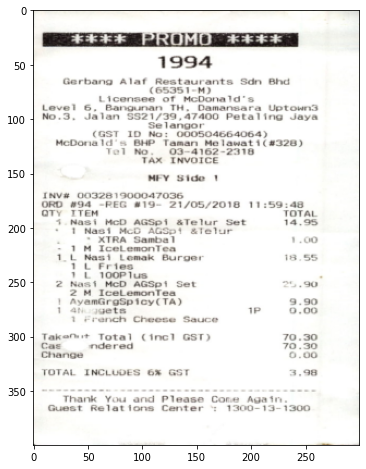

Labels: GERBANG ALAF RESTAURANTS SDN BHD [NL] LEVEL 6, BANGUNAN TH, DAMANSARA UPTOWN3 NO.3, JALAN SS21/39,47400 PETALING JAYA SELANGOR
Pred: DENNISSON & LAF FRIENDSA PARATIMULI SDN BHD [NL] LOVEL 6, RANCHARAN TA, DANHAM LA UPPRESS | LOVEL 6, RANRANGE CIS, CYLAND PETELLING 



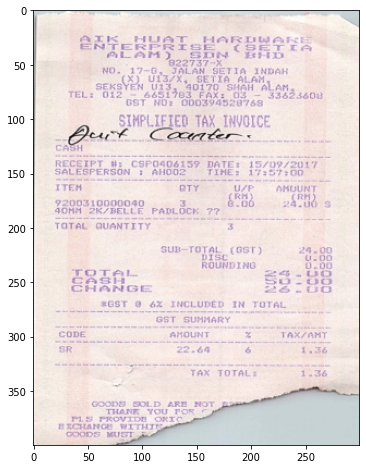

Labels: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Pred: ASM RASS CRAFT SDN BHD [NL] NO. 15/76, JALAN SERTA, LONG SIZE, JALAN SERTA, JALAN SERTA, JALAN SERTA, JALAN SERTA, SEL



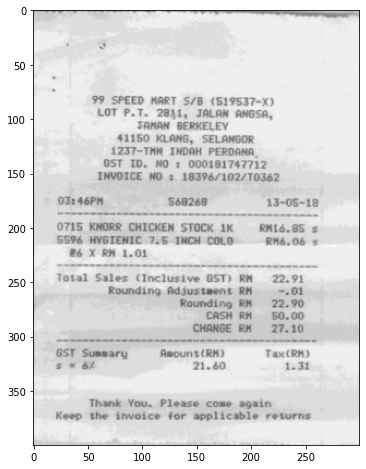

Labels: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGSA, TAMAN BERKELEY 41150 KLANG, SELANGOR 1237-TMN INDAH PERDANA
Pred: 99 SPEED MART S/B [NL] LOT P.T. 2811, JALAN ANGOA, TUMAMA BERKELEY 41150 KLANG, SELANGOR 1181-TAN KANGO, SELANGOR



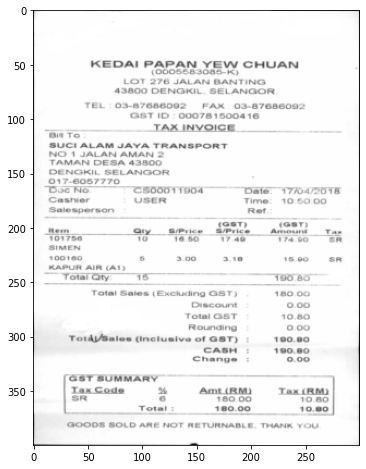

Labels: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR
Pred: KESSLE PARAW TER CHARGE [NL] LOT 236 JALAN HARING 4000 DUNHILL SELANGOR.



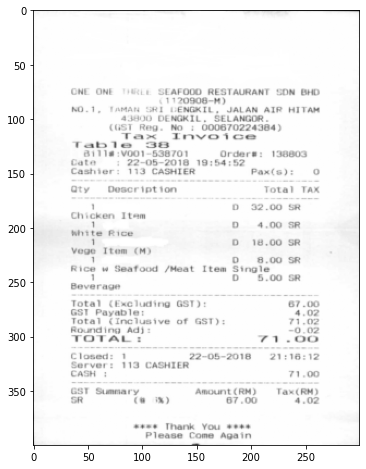

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: USE UNE, MAKE 5 FORNASS RICHMOND SDN BHD [NL] NO.1 JALAN JEALAN JALAN JEALAN



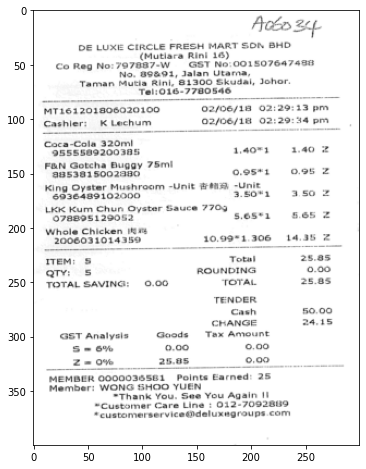

Labels: DE LUXE CIRCLE FRESH MART SDN BHD [NL] NO.89&91, JALAN UTAMA, TAMAN MUTIA RINI, 81300 SKUDAI, JOHOR.
Pred: LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCKY LUCK



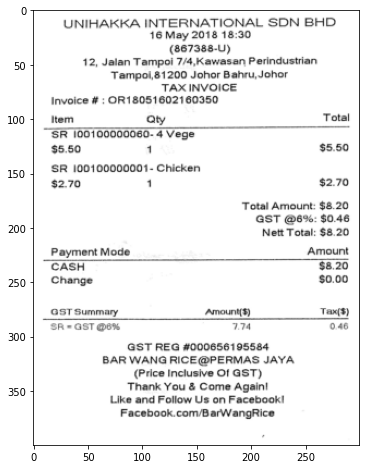

Labels: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Pred: DEANIAA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPO] 7/4,KAWASAN PERINDUSTRYIAN TAMPO]81200 JOHN BAHW,JOHN



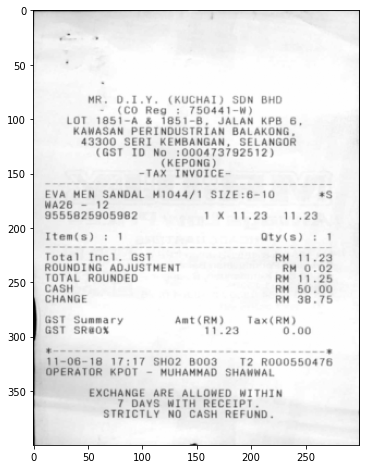

Labels: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (BUDGET) SDN BHD [NL] LOT 1851-A & 1851-S, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEANAWAW



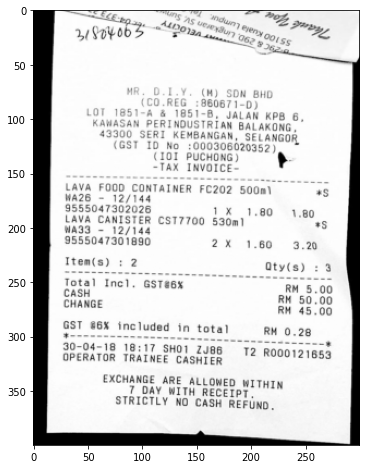

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.V. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRYIAN BALAKONG, 43300 SERI KEANANAANA, J



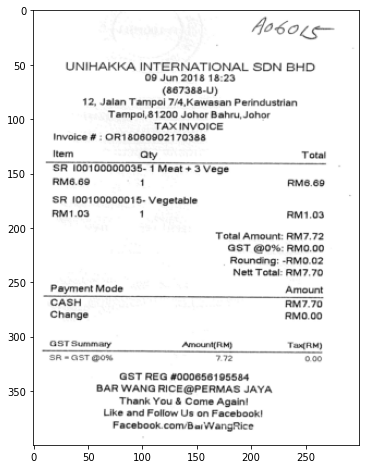

Labels: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR
Pred: UNIHAKKA INTERNATIONAL SDN BHD [NL] 12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR



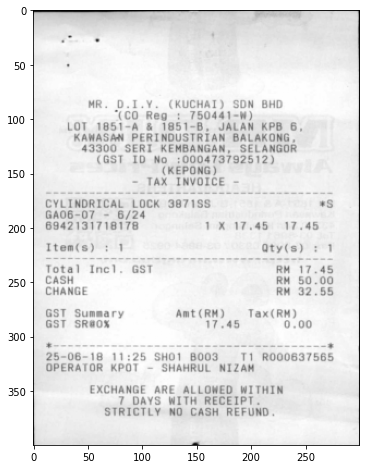

Labels: MR. D.I.Y. (KUCHAI) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.V. (BUDGET) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANG



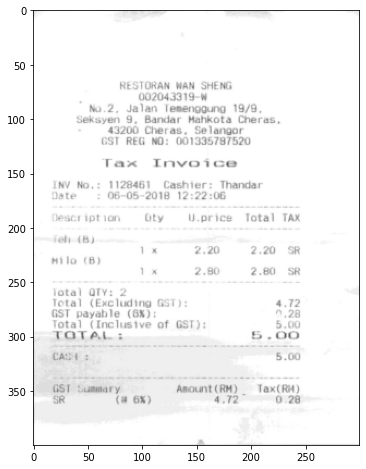

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHONG [NL] NO.2, JALAN TERHUNE 19, SELSELS, D.ALAN TERHUNE 19,



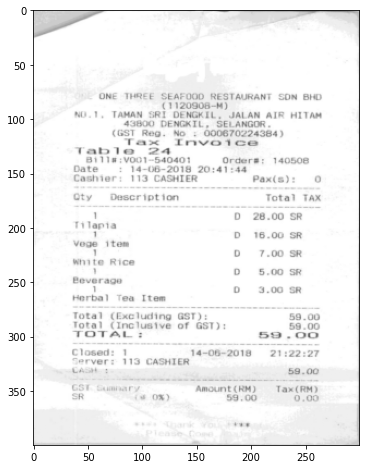

Labels: ONE ONE THREE SEAFOOD RESTAURANT SDN BHD [NL] NO. 1, TAMAN SRI DENGKIL, JALAN AIR HITAM 43800 DENGKIL, SELANGOR.
Pred: DR. MAKE J LICENSE SDN BHD [NL] NO. J. JALAN JEDDOR, JALAN JEDDOR, JALAN JEDDOR, JALAN JEDDOR,



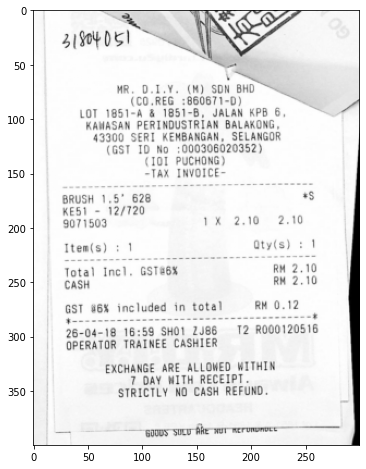

Labels: MR. D.I.Y. (M) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR
Pred: MR. D.I.Y. (A) SDN BHD [NL] LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALANCE, 43300 SERI KEMBANGAN.



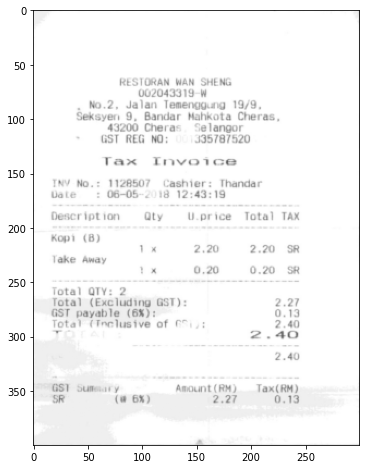

Labels: RESTORAN WAN SHENG [NL] NO.2, JALAN TEMENGGUNG 19/9, SEKSYEN 9, BANDAR MAHKOTA CHERAS, 43200 CHERAS, SELANGOR
Pred: RESTORAN WAN SHENG [NL] NO.2, JALAN TIMENGENG 19, SERIES 9, BANDAND MARQUIN CHUNG, SERIES COURSE, SELANGOR



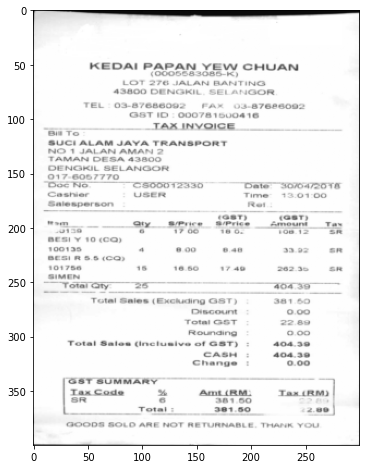

Labels: KEDAI PAPAN YEW CHUAN [NL] LOT 276 JALAN BANTING 43800 DENGKIL, SELANGOR
Pred: KUDAI PARAW TERK CHANCE [NL] LOT 276 JALAN BAVEING 4100 DRAWKK, SELANGOR.



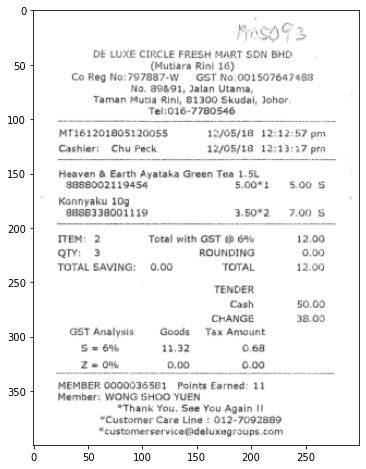

Labels: DE LUXE CIRCLE FRESH MART SDN BHD [NL] NO. 89&91, JALAN UTAMA, TAMAN MUTIA RINI, 81300 SKUDAI, JOHOR.
Pred: DE LEAF ERATING SDN BHD [NL] NO.6L/KF DEALAN DEALER PERSONAL JAUG KAUL DEALAN JAUG



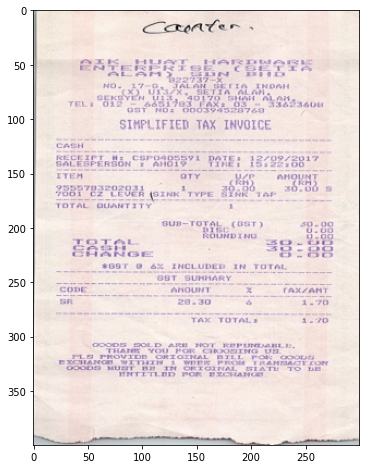

Labels: AIK HUAT HARDWARE ENTERPRISE (SETIA ALAM) SDN BHD [NL] NO. 17-G, JALAN SETIA INDAH (X) U13/X, SETIA ALAM, SEKSYEN U13, 40170 SHAH ALAM,
Pred: KONG YANG JALAN JONES JALAN JONES JALAN JONES JONES JONES JONES JONES JONES JONES JONES JONES JONES JONES JONES JONES JONES 



In [36]:
batch = next(iter(test_dl))
batch[0] = batch[0].cuda()

test_model.eval()

with torch.no_grad():
    pred_tokens = test_model(batch)

decoded_preds = [test_model.tokenizer.decode(t) for t in pred_tokens]

images, labels, tokens = batch

for image, label, pred in zip(images, labels, decoded_preds):
    plt.figure(figsize=(6, 8))
    plt.imshow(((image.squeeze(0).cpu().numpy().transpose(1, 2, 0)/2+1)))
    plt.show()
    print(f'Labels: {label}\nPred: {pred}\n')

## Observações

**1. Essa aborgagem foi a que obteve menor performance atingindo 35.82%.**